---
# CARREGAR DATASET
---

In [82]:
import numpy as np
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
#from tensorflow.keras.models  import Sequential
#from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

RANDOM_SEED = 2022

In [83]:
df = pd.read_csv('cardio_train.csv', sep=";")

---
# EXPLORAÇÃO DE DADOS
---

## <u>Atributos</u>

In [84]:
# Quais são os atributos e os seus tipos, e qual a quantidade de 'missing values'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## <u>Tipos de valores</u>
Esta subsecção serve para:
- Verificar a discrepância entre a quantidade de amostras associadas às categorias de um atributo (pode levar a overfit)
- Identificação de valores que não deveriam existir

#### Atributos categóricos


In [85]:
'''
Género (deve ser binária):

BIASED
'''

df['gender'].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

In [86]:
'''
Colesterol (deve ser ternária):
    -> 1: normal
    -> 2: acima do normal
    -> 3: bem acima do normal

BIASED
'''
df['cholesterol'].value_counts()

1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64

In [87]:
'''
Glucose (deve ser ternária):
    -> 1: normal
    -> 2: acima do normal
    -> 3: bem acima do normal

BIASED
'''
df['gluc'].value_counts()

1    59479
3     5331
2     5190
Name: gluc, dtype: int64

In [88]:
'''
É fumador (deve ser binária):
    -> 0: não
    -> 1: sim

BIASED
'''
df['smoke'].value_counts()

0    63831
1     6169
Name: smoke, dtype: int64

In [89]:
'''
Ingere álcool (deve ser binária):
    -> 0: não
    -> 1: sim

BIASED
'''
df['alco'].value_counts()

0    66236
1     3764
Name: alco, dtype: int64

In [90]:
'''
Pratica desporto (deve ser binária):
    -> 0: não
    -> 1: sim

BIASED
'''
df['active'].value_counts()

1    56261
0    13739
Name: active, dtype: int64

In [91]:
'''
Presença de doença cardio vascular [Variável objetivo] (deve ser binária):
    -> 0: não
    -> 1: sim
'''
df['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

#### Atributos contínuos

In [92]:
def get_outliers(frame : pd.DataFrame, column : str):
    sorted_frame = frame.sort_values(by=column, ascending=True)
    q1 = frame[column].quantile(0.25)
    q3 = frame[column].quantile(0.75)
    iqr = q3-q1
    lim_inf = q1 - 1.5*iqr
    lim_sup = q3 + 1.5*iqr
    return frame.loc[(frame[column] < lim_inf) | (frame[column] > lim_sup)]

def remove_outliers(frame : pd.DataFrame, column : str):
    return frame.drop(get_outliers(frame, column))

In [93]:
for attr in ['age', 'height', 'weight', 'ap_hi', 'ap_lo']:
    print(f"Nr de outliers da feature '{attr}': {get_outliers(df,attr).shape[0]}")

Nr de outliers da feature 'age': 4
Nr de outliers da feature 'height': 519
Nr de outliers da feature 'weight': 1819
Nr de outliers da feature 'ap_hi': 1435
Nr de outliers da feature 'ap_lo': 4632


'\nConclusões: ...\n\n'

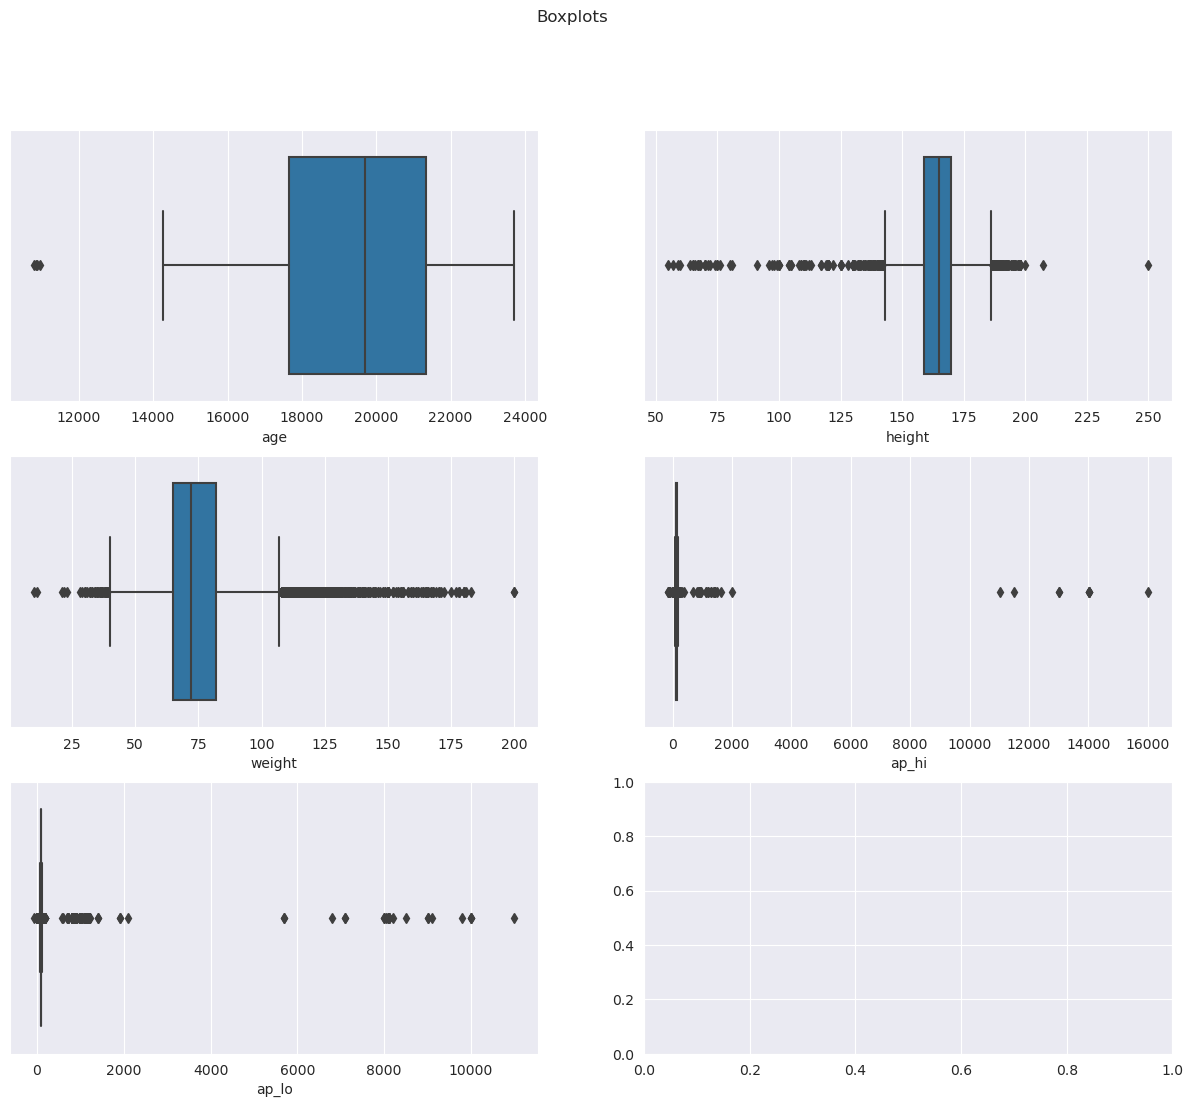

In [94]:
#Boxplots para visualização de outliers
fig, axs = plt.subplots(3,2, figsize = (15,12))
fig.suptitle("Boxplots")
sns.boxplot(x=df['age'], ax=axs[0,0])
sns.boxplot(x=df['height'], ax=axs[0,1])
sns.boxplot(x=df['weight'], ax=axs[1,0])
sns.boxplot(x=df['ap_hi'], ax=axs[1,1])
sns.boxplot(x=df['ap_lo'], ax=axs[2,0])

'''
Conclusões: ...

'''

<AxesSubplot:xlabel='ap_lo', ylabel='Count'>

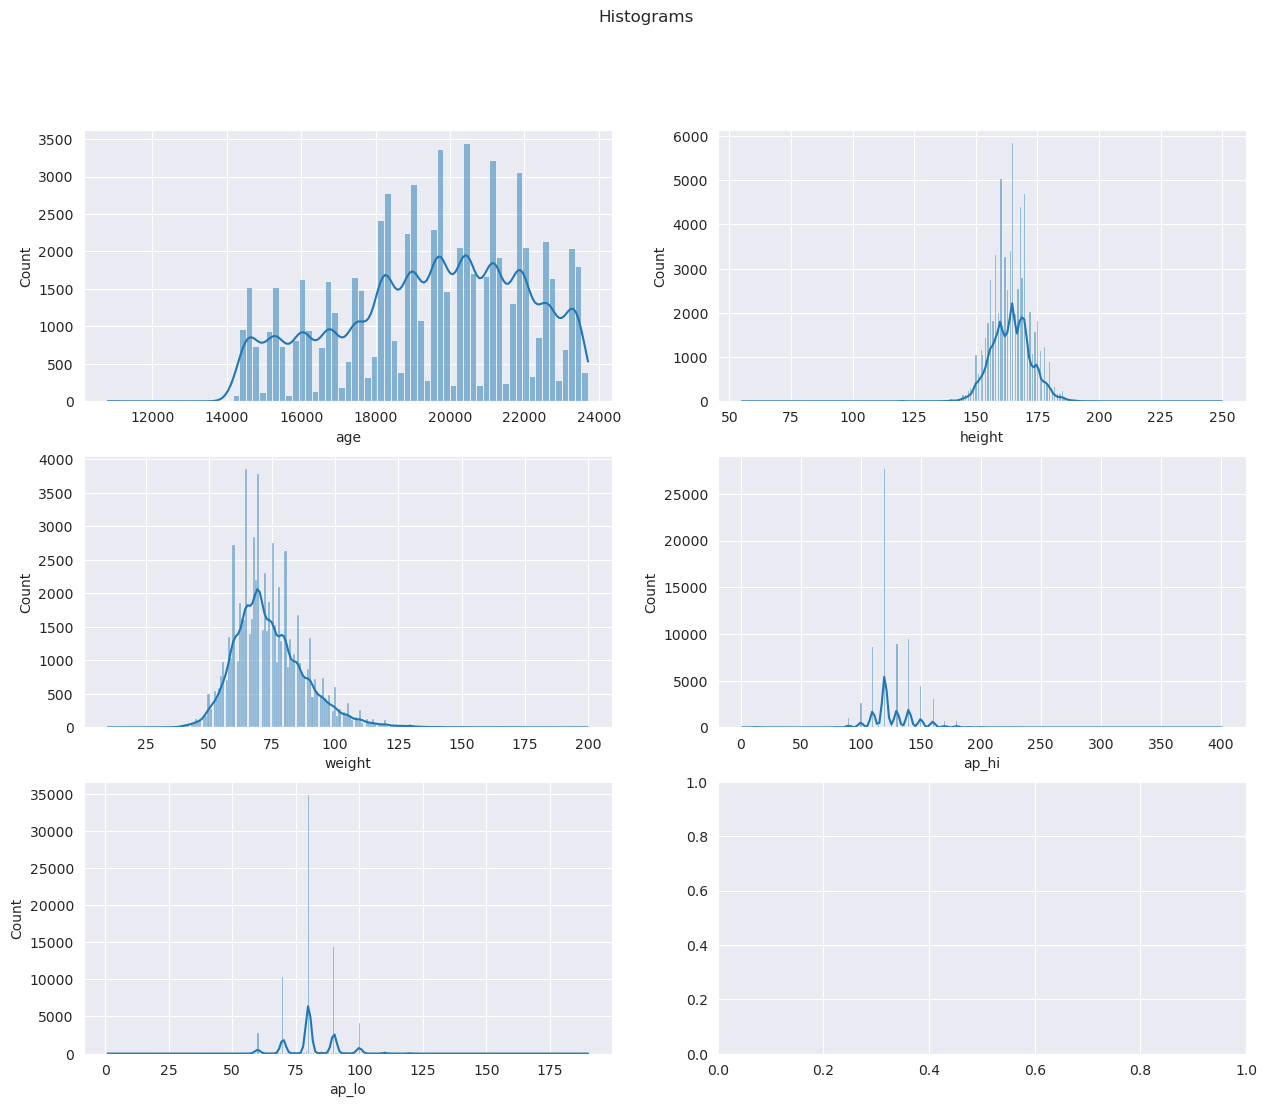

In [95]:
fig, axs = plt.subplots(3,2, figsize = (15,12))
fig.suptitle("Histograms")
sns.histplot(df["age"], ax=axs[0,0], kde=True)
sns.histplot(df["height"], ax=axs[0,1], kde=True)
sns.histplot(df["weight"], ax=axs[1,0], kde=True)
sns.histplot(df["ap_hi"].loc[(df["ap_hi"] > 0) & (df["ap_hi"] < 500)], ax=axs[1,1], kde=True) # plot com apenas valores acima de 0 e abaixo de 500 para ser possível observar melhor o comportamento dos dados (mesmo com esta restricao ainda existem valores (outliers) impossiveis)
sns.histplot(df["ap_lo"].loc[(df["ap_lo"] > 0) & (df["ap_lo"] < 500)], ax=axs[2,0], kde=True) # plot com apenas valores  acima de 0 e abaixo de 500 para ser possível observar melhor o comportamento dos dados (mesmo com esta restricao ainda existem valores (outliers) impossiveis)

## <u>Tendência Central</u>

In [96]:
#Média, desvio padrão, percentis, mínimo e máximo
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [97]:
#Mediana
df.median()

id             50001.5
age            19703.0
gender             1.0
height           165.0
weight            72.0
ap_hi            120.0
ap_lo             80.0
cholesterol        1.0
gluc               1.0
smoke              0.0
alco               0.0
active             1.0
cardio             0.0
dtype: float64

In [98]:
#Moda
df.mode().iloc[0]

id                 0.0
age            18236.0
gender             1.0
height           165.0
weight            65.0
ap_hi            120.0
ap_lo             80.0
cholesterol        1.0
gluc               1.0
smoke              0.0
alco               0.0
active             1.0
cardio             0.0
Name: 0, dtype: float64

In [99]:
print(f"Skewness: \n{df.skew()}")
print(f"\nKurtosis: \n{df.kurt()}")

Skewness: 
id             -0.001278
age            -0.307055
gender          0.630960
height         -0.642187
weight          1.012070
ap_hi          85.296214
ap_lo          32.114083
cholesterol     1.587123
gluc            2.397462
smoke           2.905867
alco            3.956607
active         -1.529473
cardio          0.001200
dtype: float64

Kurtosis: 
id               -1.198374
age              -0.823447
gender           -1.601935
height            7.943653
weight            2.586825
ap_hi          7580.074738
ap_lo          1425.914585
cholesterol       0.993901
gluc              4.294377
smoke             6.444250
alco             13.655125
active            0.339296
cardio           -2.000056
dtype: float64


## <u>Correlação entre atributos</u>

<AxesSubplot:>

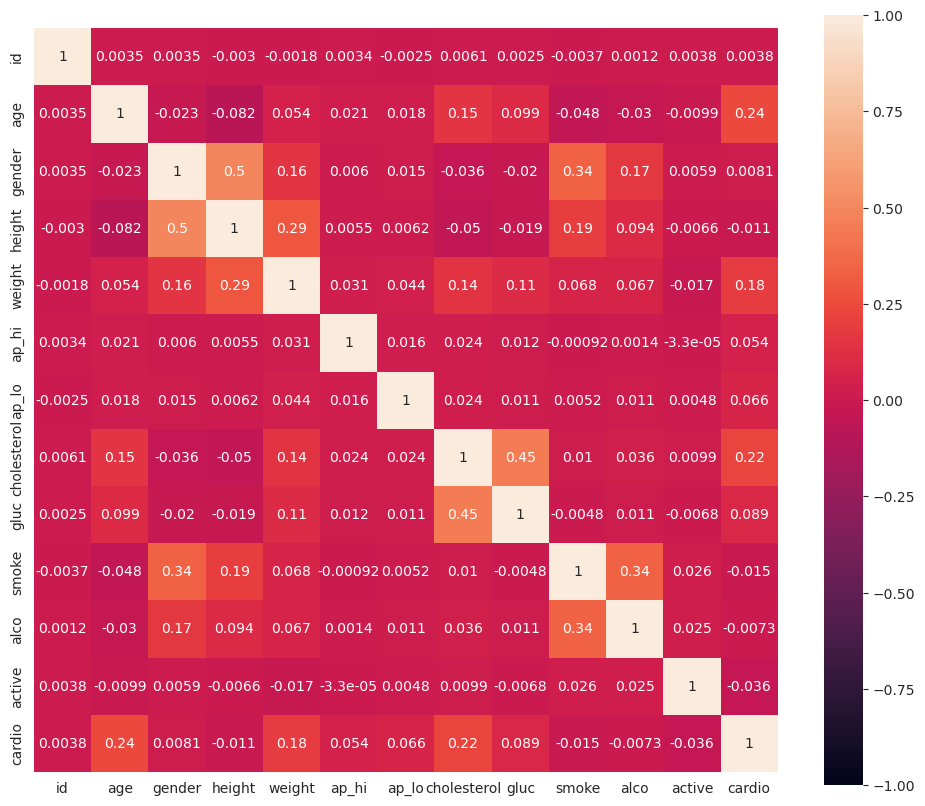

In [100]:
corr_matrix = df.corr()
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)

---
# TRATAMENTO DE DADOS
---

In [101]:
#Entradas duplicadas
print("Nº de entradas duplicadas: ", df.duplicated().sum())

Nº de entradas duplicadas:  0


## Feature Engineering

### Conversão da idade em dias para idade em anos

In [102]:
import math

def calculate_age(days):
    return math.floor(days / 365.0)

In [103]:
df['age'] = df['age'].apply(calculate_age)

### Binning da idade

In [104]:
def bin_age(age):
    if age < 30:
        return 1
    elif age < 40:
        return 2
    elif age < 50:
        return 3
    elif age < 60:
        return 4
    else:
        return 5

In [105]:
df['age_binned'] = df['age'].apply(bin_age)

### Criação do atributo BMI (Indice de massa corporal)

In [106]:
# BMI = weight / height^2
df['BMI'] = df.weight / ((df.height / 100) * (df.height / 100))

### Binning do indice de massa corporal

In [107]:
def bin_bmi(bmi):
    if bmi < 18.5: # underweight
        return 1
    elif bmi < 25: # normal
        return 2
    elif bmi < 30: # overweight
        return 3
    elif bmi < 35: # obese
        return 4
    else:          # extremely obese
        return 5

In [108]:
df['BMI_binned'] = df['BMI'].apply(bin_bmi)

### Remoção de outliers

In [109]:
# FILTRAR POR VALORES NORMAIS
df = df.drop(df.loc[(df['height'] < 130) | (df['height'] > 210)].index)
df = df.drop(df.loc[df['weight'] < 40].index)
df = df.drop(df.loc[(df['ap_hi'] > 360) | (df['ap_hi'] < 30)].index)
df = df.drop(df.loc[(df['ap_lo'] > 250) | (df['ap_lo'] < 30)].index)
df = df.drop(df.loc[df['BMI'] > 50].index)

In [110]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_binned,BMI,BMI_binned
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,4,21.967120,2
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,4,34.927679,4
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,4,23.507805,2
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,3,28.710479,3
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,3,23.011177,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,57,1,165,80.0,150,80,1,1,0,0,1,1,4,29.384757,3
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0,4,26.927438,3
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,4,31.353579,4
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,5,27.099251,3


In [111]:
print(f"Skewness: \n{df.skew()}")
print(f"\nKurtosis: \n{df.kurt()}")

Skewness: 
id            -0.001038
age           -0.303535
gender         0.632294
height         0.125157
weight         0.815049
ap_hi          0.903845
ap_lo          0.635134
cholesterol    1.598504
gluc           2.407143
smoke          2.905496
alco           3.961547
active        -1.526730
cardio         0.021874
age_binned    -0.140127
BMI            0.988111
BMI_binned     0.608202
dtype: float64

Kurtosis: 
id             -1.198020
age            -0.821411
gender         -1.600251
height          0.161804
weight          1.219652
ap_hi           1.839486
ap_lo           4.253273
cholesterol     1.031284
gluc            4.341492
smoke           6.442097
alco           13.694251
active          0.330914
cardio         -1.999580
age_binned     -0.421286
BMI             1.224128
BMI_binned     -0.477088
dtype: float64


<AxesSubplot:xlabel='BMI'>

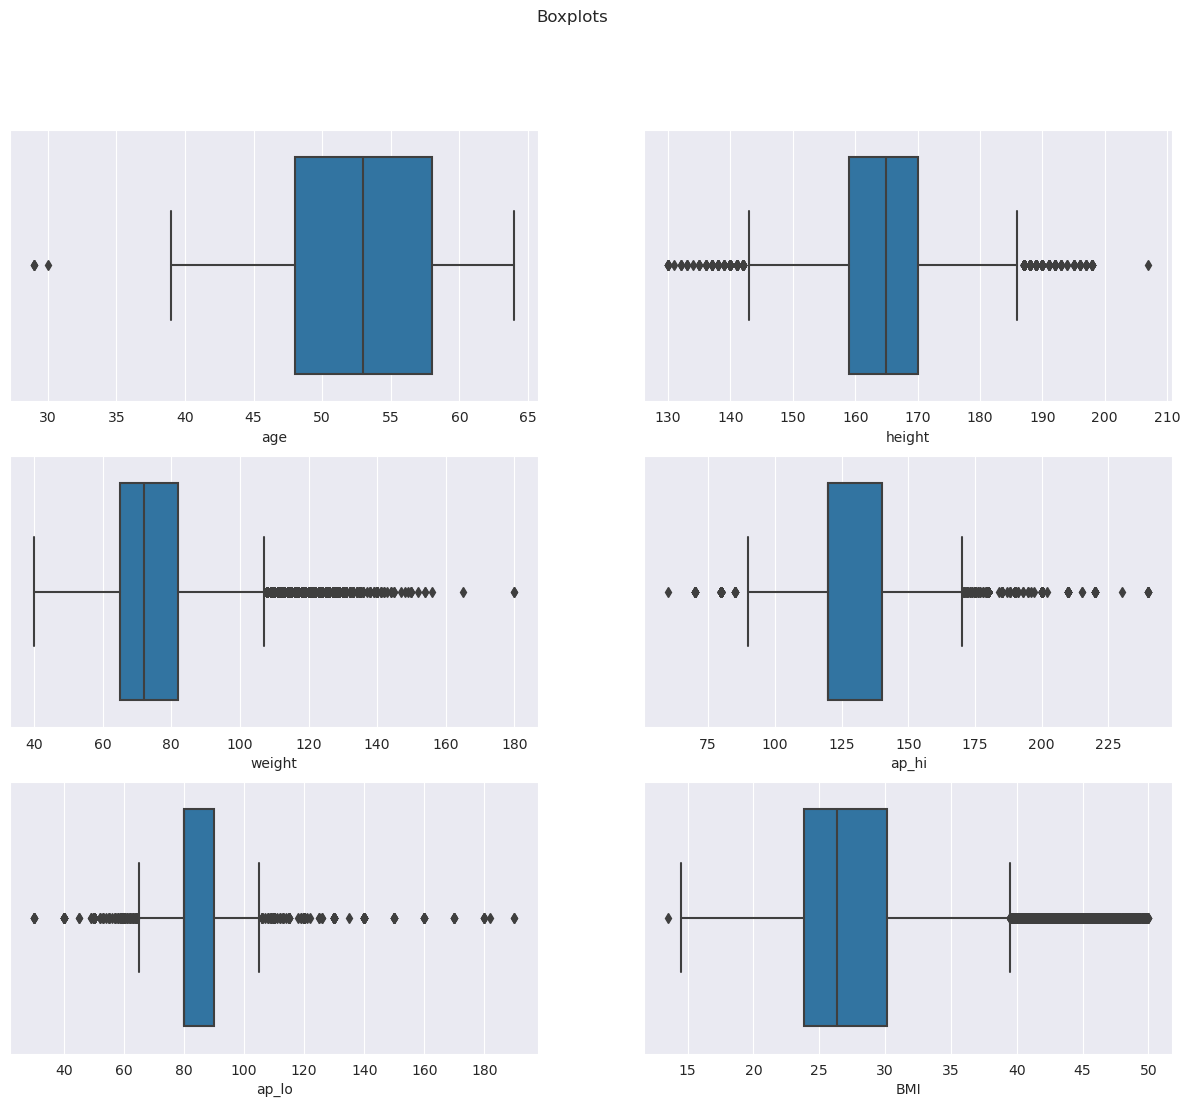

In [112]:
fig, axs = plt.subplots(3,2, figsize = (15,12))
fig.suptitle("Boxplots")
sns.boxplot(x=df['age'], ax=axs[0,0])
sns.boxplot(x=df['height'], ax=axs[0,1])
sns.boxplot(x=df['weight'], ax=axs[1,0])
sns.boxplot(x=df['ap_hi'], ax=axs[1,1])
sns.boxplot(x=df['ap_lo'], ax=axs[2,0])
sns.boxplot(x=df['BMI'], ax=axs[2,1])

---
# MODELOS
---

## Decision Tree Classifier

In [113]:
x = df.drop(['id', 'cardio', 'weight', 'height', 'BMI'], axis=1)
y = df['cardio'].to_frame()

In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(random_state=2022, criterion='gini', max_depth=10)
scores = cross_val_score(clf, x, y, cv=10)
print(scores)
print('RESULT: %0.2f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))
print(scores.mean())

[0.72813549 0.7260914  0.7347058  0.73382976 0.71630895 0.72813549
 0.72565338 0.73280771 0.72784348 0.73057827]
RESULT: 0.73 accuracy with a standard deviation of 0.01
0.7284089732555268


In [115]:
from sklearn.model_selection import train_test_split

best_accuracy = 0
best_criterion = ""
best_max_depth = 0

for i in range(1,10):
    for c in ["gini","entropy"]:
        clf = DecisionTreeClassifier(random_state=2022, criterion=c, max_depth=i)
        scores = cross_val_score(clf, x, y, cv=10)
        new_acc = scores.mean()
        if new_acc > best_accuracy:
            best_accuracy = new_acc
            best_criterion = c
            best_max_depth = i

print("Best accuracy:", best_accuracy)
print("best_criterion:", best_criterion)
print("best_max_depth:", best_max_depth)

Best accuracy: 0.7322489157807335
best_criterion: entropy
best_max_depth: 7


## MultiLayer Perceptron Model

In [116]:
x = df.drop(["cardio","id","BMI_binned","age_binned"],axis=1)
y = df[["cardio"]]

scaler_x = MinMaxScaler(feature_range=(0,1)).fit(x)
scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y)
x_scaled = pd.DataFrame(scaler_x.transform(x[x.columns]),columns=x.columns)
y_scaled = pd.DataFrame(scaler_y.transform(y[y.columns]),columns=y.columns)

In [117]:
x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI
0,50,2,168,62.0,110,80,1,1,0,0,1,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,34.927679
2,51,1,165,64.0,130,70,3,1,0,0,0,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,28.710479
4,47,1,156,56.0,100,60,1,1,0,0,0,23.011177


In [118]:
x_scaled.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI
0,0.600000,1.0,0.493506,0.157143,0.277778,0.3125,0.0,0.0,0.0,0.0,1.0,0.231538
1,0.742857,0.0,0.337662,0.321429,0.444444,0.3750,1.0,0.0,0.0,0.0,1.0,0.586824
2,0.628571,0.0,0.454545,0.171429,0.388889,0.2500,1.0,0.0,0.0,0.0,0.0,0.273772
3,0.542857,1.0,0.506494,0.300000,0.500000,0.4375,0.0,0.0,0.0,0.0,1.0,0.416393
4,0.514286,0.0,0.337662,0.114286,0.222222,0.1875,0.0,0.0,0.0,0.0,0.0,0.260158


In [119]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=RANDOM_SEED)

In [120]:
def build_model(activation="relu",learning_rate=0.01):
    #Create a sequential
    model = Sequential()
    model.add(Dense(16, input_dim=12, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation="relu"))

    #Compile the model
    #
    model.compile(
        loss="mae",
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ["mae","mse"])
    return model

In [121]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                208       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [122]:
model.summary()
TUNING_DICT = {
    "activation": ["relu", "sigmoid"],
    "learning_rate": [0.02, 0.001]
}

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                208       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [123]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

model = KerasRegressor(build_fn=build_model, epochs=20,batch_size=32)
grid_search = GridSearchCV(estimator=model,
                           param_grid= TUNING_DICT,
                           cv = kf,
                           scoring="neg_mean_absolute_error",
                           refit="True",
                           verbose = 1)

grid_search.fit(x_train,y_train,validation_split=0.2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Epoch 1/20


/tmp/ipykernel_12558/1029624206.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, epochs=20,batch_size=32)


1096/1096 [==============================] - 4s 3ms/step - loss: 0.4960 - mae: 0.4960 - mse: 0.4959 - val_loss: 0.5002 - val_mae: 0.5002 - val_mse: 0.5002
Epoch 2/20
1096/1096 [==============================] - 3s 3ms/step - loss: 0.4959 - mae: 0.4959 - mse: 0.4959 - val_loss: 0.5002 - val_mae: 0.5002 - val_mse: 0.5002
Epoch 3/20
1096/1096 [==============================] - 3s 3ms/step - loss: 0.4959 - mae: 0.4959 - mse: 0.4959 - val_loss: 0.5002 - val_mae: 0.5002 - val_mse: 0.5002
Epoch 4/20
1096/1096 [==============================] - 3s 3ms/step - loss: 0.4959 - mae: 0.4959 - mse: 0.4959 - val_loss: 0.5002 - val_mae: 0.5002 - val_mse: 0.5002
Epoch 5/20
1096/1096 [==============================] - 3s 3ms/step - loss: 0.4959 - mae: 0.4959 - mse: 0.4959 - val_loss: 0.5002 - val_mae: 0.5002 - val_mse: 0.5002
Epoch 6/20
1096/1096 [==============================] - 4s 3ms/step - loss: 0.4959 - mae: 0.4959 - mse: 0.4959 - val_loss: 0.5002 - val_mae: 0.5002 - val_mse: 0.5002
Epoch 7/20
1096

GridSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f3e28518250>,
             param_grid={'activation': ['relu', 'sigmoid'],
                         'learning_rate': [0.02, 0.001]},
             refit='True', scoring='neg_mean_absolute_error', verbose=1)

In [124]:
print("Best : %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_["mean_test_score"]
stds = grid_search.cv_results_["std_test_score"]
params = grid_search.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f  (%f) with: %r" % (mean, stdev, param))

Best : -0.320759 using {'activation': 'relu', 'learning_rate': 0.001}
-0.409915  (0.104905) with: {'activation': 'relu', 'learning_rate': 0.02}
-0.320759  (0.090156) with: {'activation': 'relu', 'learning_rate': 0.001}
-0.452833  (0.086999) with: {'activation': 'sigmoid', 'learning_rate': 0.02}
-0.413836  (0.100364) with: {'activation': 'sigmoid', 'learning_rate': 0.001}


In [41]:
best_mlp_model = grid_search.best_estimator_

predictions = best_mlp_model.predict(x_test)
predictions = predictions.reshape(predictions.shape[0],1)
predictions[:5]

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
predictions_unscaled = scaler_y.inverse_transform(predictions)
predictions_unscaled[:5]

In [ ]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_test_unscaled[:5]

In [ ]:
print("MAE:", metrics.mean_absolute_error(y_test,predictions))
print("MSE:", metrics.mean_squared_error(y_test,predictions))
print("RMSE:", np.sqrt(metrics.mean_absolute_error(y_test,predictions)))